In [11]:
import datetime
import warnings
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List

from dateutil.relativedelta import relativedelta

from tqdm.notebook import tqdm

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

Попробуем наколдовать ансамбль из нейронной сети с двумя входами и модели LGBM.

In [12]:
df_true = pd.read_csv('data_for_train/3.6/df_true.csv', index_col=0)
df_true.index = pd.to_datetime(df_true.index, format='%Y-%m-%d')
print('df_true.shape', df_true.shape)
df_true.head(2)

df_true.shape (182, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2022-12-01,4285.977829,4121.104164,4016.489238,3982.370123,4029.681601,4218.929298,4591.981078,5134.041701,5549.132725,5709.592049,...,5496.492343,5381.461570,5375.812472,5474.761907,5506.371736,5412.561663,5325.417866,5194.726915,4904.46684,4562.051842
2022-12-02,4287.533250,4200.230592,4143.434946,4113.156603,4139.008368,4280.217473,4695.130472,5242.160182,5684.420320,5777.843229,...,5494.242586,5359.932844,5311.905591,5481.952022,5519.806361,5420.776841,5299.009196,5149.812325,4878.80910,4554.771869


In [13]:
df_pred_NN = pd.read_csv('data_for_train/3.6/df_pred_NN.csv', index_col=0)
df_pred_NN.index = pd.to_datetime(df_pred_NN.index, format='%Y-%m-%d')
print('df_pred_NN.shape', df_pred_NN.shape)
df_pred_NN.head(2)

df_pred_NN.shape (182, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2022-12-01,4164.6426,4046.1850,3969.0527,3940.6333,3953.6380,4126.2330,4525.1655,5041.3325,5480.9180,5710.618,...,5465.704,5394.9126,5345.749,5342.3574,5351.5806,5292.6577,5207.668,5047.2905,4731.3354,4402.3486
2022-12-02,4232.4404,4109.6597,4030.6700,4007.3174,4014.8696,4177.2793,4552.5396,5040.0107,5472.1553,5707.429,...,5455.185,5367.2850,5320.970,5322.7153,5342.0840,5283.2420,5208.765,5063.6655,4754.1880,4434.9470


In [14]:
df_pred_LGBM = pd.read_csv('data_for_train/3.6/df_pred_LGBM.csv', index_col=0)
df_pred_LGBM.index = df_true.index
df_pred_LGBM.columns = df_true.columns
# df_pred_LGBM.index = pd.to_datetime(df_pred_LGBM.index, format='%Y-%m-%d')
print('df_pred_LGBM.shape', df_pred_LGBM.shape)
df_pred_LGBM.head(2)

df_pred_LGBM.shape (182, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2022-12-01,4247.002024,4128.598406,4078.007808,4057.806771,4097.998546,4244.455571,4640.034905,5211.567410,5674.957975,5757.950390,...,5561.576866,5486.992679,5470.911854,5561.123619,5580.187484,5482.843017,5388.361004,5257.765321,4879.992577,4546.217836
2022-12-02,4311.200654,4154.522846,4111.428194,4087.824396,4061.755356,4228.820347,4654.755647,5162.558543,5631.559043,5761.667369,...,5535.848439,5465.690240,5390.418166,5480.284804,5538.581728,5364.240222,5260.000162,5165.834144,4869.102801,4539.796547


In [15]:
df_pred_ensemble = (df_pred_LGBM + df_pred_NN) / 2
print('df_pred_ensemble.shape', df_pred_ensemble.shape)
df_pred_ensemble.head(2)

df_pred_ensemble.shape (182, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2022-12-01,4205.822312,4087.391703,4023.530254,3999.220036,4025.818273,4185.344285,4582.600203,5126.449955,5577.937987,5734.284195,...,5513.640433,5440.952639,5408.330427,5451.740510,5465.884042,5387.750359,5298.014502,5152.527910,4805.663989,4474.283218
2022-12-02,4271.820527,4132.091273,4071.049097,4047.570898,4038.312478,4203.049823,4603.647624,5101.284621,5551.857172,5734.548185,...,5495.516719,5416.487620,5355.694083,5401.500052,5440.332864,5323.741111,5234.382581,5114.749822,4811.645401,4487.371774


In [16]:
def plot_predicts(df_true   : pd.DataFrame,
                  df_pred   : pd.DataFrame,
                  days_shift: int = 1) -> None:
    """
    Функция для отображения графиков
    принимает на вход датафреймы с инедксами с дневной резолюцией и 24 колнками,
    а также число дней, на которые нужно сдвинуть индексы для отображения
    """
    date_start = (df_true.index[0] + datetime.timedelta(days=days_shift)).date()
    date_end = (df_true.index[-1] + datetime.timedelta(days=days_shift)).date()

    print(f'Реальные и предсказанные значения за период {date_start} - {date_end}'.center(180, "-"))

    _, axes = plt.subplots(nrows=len(df_true)//7,
                           ncols=7,
                           figsize=(14, 2*len(df_true)//7 + 3))

    for i in range(len(df_true)//7):

        for j in range(7):

            ax = axes[i, j]

            ax.plot(range(24), df_true.iloc[i*7 + j], color='blue')
            ax.plot(range(24), df_pred.iloc[i*7 + j], alpha=0.5, color='red')
            
            ax.set_xticks(range(0, 24, 4))
            ax.set_yticks([])

            date = (df_true.index[i*7 + j] + datetime.timedelta(days=days_shift)).date()
            mae = mean_absolute_error(df_true.iloc[i*7 + j], df_pred.iloc[i*7 + j]).round(3)
            new_line = '\n'
            ax.set_title(f'{date}{new_line}MAE: {mae}')

    plt.tight_layout()
    plt.show()

    return None

In [17]:
print('MSE :', mean_squared_error(df_true, df_pred_ensemble).round(3))
print('MAE :', mean_absolute_error(df_true, df_pred_ensemble).round(3))

MSE : 8074.69
MAE : 68.558


--------------------------------------------------------Реальные и предсказанные значения за период 2022-12-01 - 2023-05-31---------------------------------------------------------


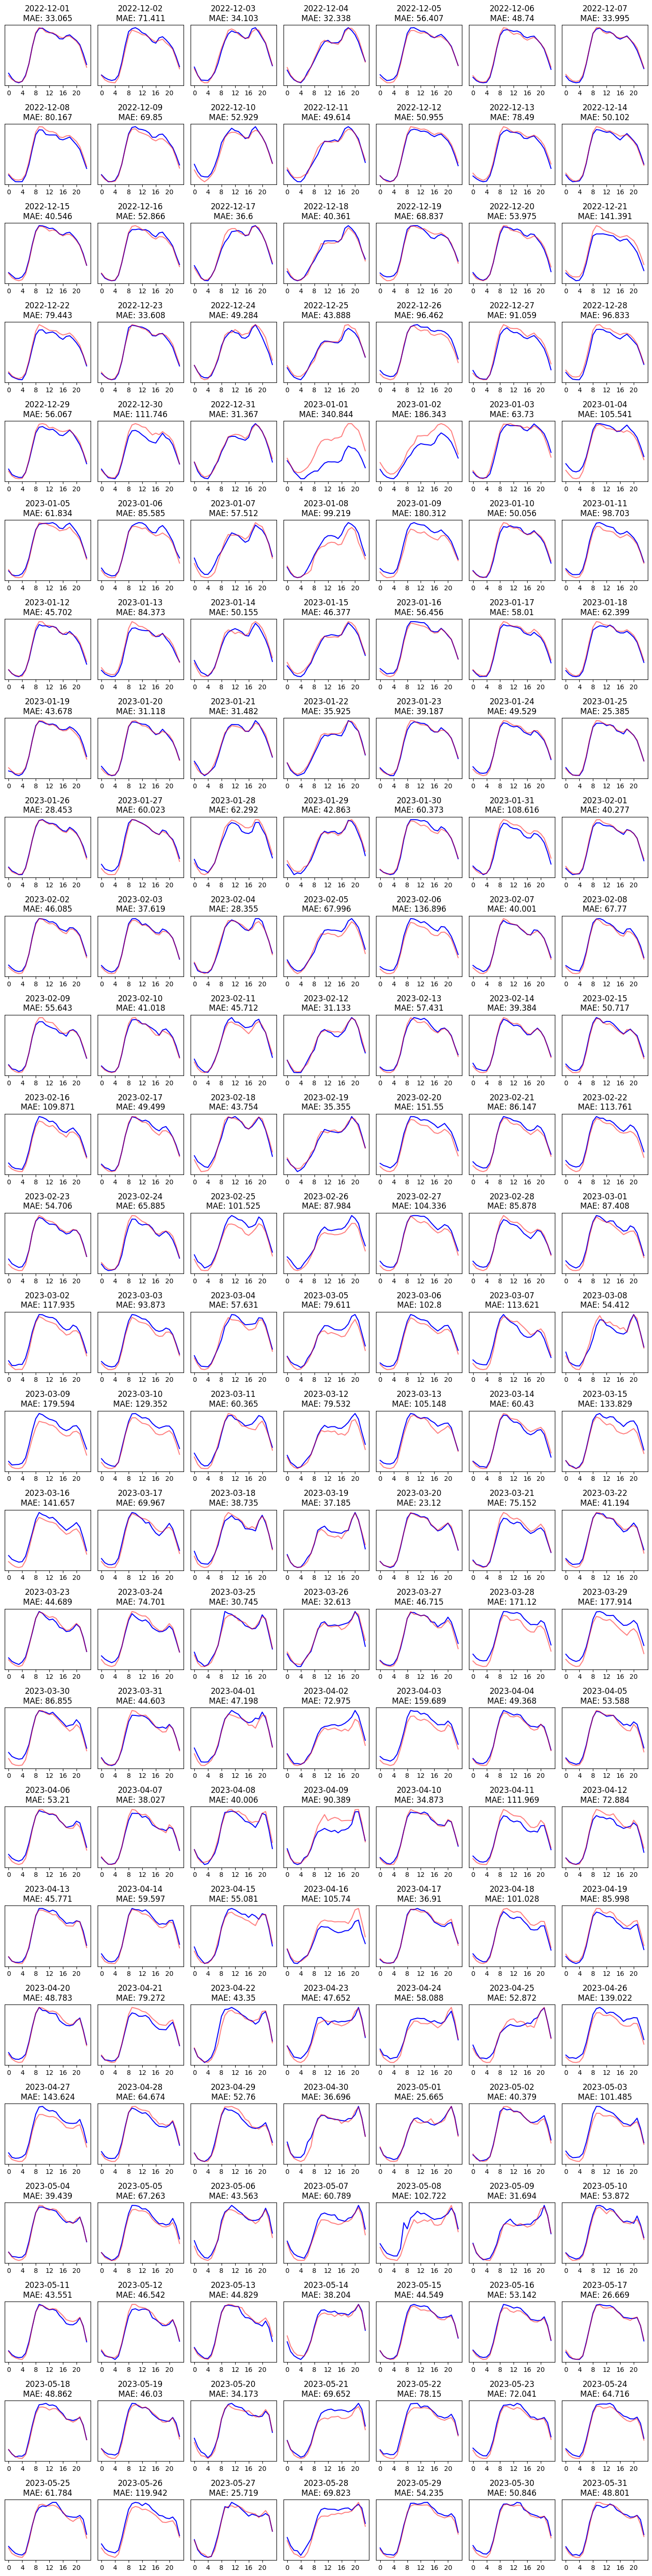

In [18]:
plot_predicts(df_true=df_true,
              df_pred=df_pred_ensemble,
              days_shift=0)